# Pune ITMS data
In this notebook we will have a look at the ITMS transit data from Pune. The data consists of two parts: 1) the static data corresponding to the different trip details (stop sequences, timings), stop details (stop_id, stop location) etc, and 2) on field data from the buses having information on the current trip undertaken by the bus, the current location of the bus, whether a bus is in transit to a stop or stopped at a stop etc. 


### Import required modules

In [0]:
import numpy as np
import pandas as pd
#import matplotlib 
#matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import folium
from folium import plugins
import os
import zipfile
import random
%matplotlib inline
import math
from pyIUDX.rs import rs
from datetime import datetime, timedelta
import pytz

Install pyIUDX from github.

In [2]:
!pip install git+https://github.com/iudx/pyIUDX --upgrade

  Cloning https://github.com/iudx/pyIUDX to /tmp/pip-req-build-ytee8ano
  Running command git clone -q https://github.com/iudx/pyIUDX /tmp/pip-req-build-ytee8ano
  Created wheel for pyIUDX: filename=pyIUDX-0.0.1-cp36-none-any.whl size=22423 sha256=be8a88fbc0f89151e029c65161c9c708fd23af509b9dded01094f03c179f203d
  Stored in directory: /tmp/pip-ephem-wheel-cache-c0ast6uy/wheels/9a/47/49/4628dcd08582cacb7599b922e10d77572044b4c49fe076e0e8
Successfully built pyIUDX
  Found existing installation: pyIUDX 0.0.1
    Uninstalling pyIUDX-0.0.1:
      Successfully uninstalled pyIUDX-0.0.1


Let's import pyIUDX to get field data of buses on a particular day. Let's say 21st November between 6AM and 12PM. Since there is a lot of data, this will take some time.
We will also need to find the id of the ITMS database from PUDX. Visit pudx.catalogue.iudx.org.in and search for ITMS to get the ID. The ID of the ITMS dataset is - 
rbccps.org/aa9d66a000d94a78895de8d4c0b3a67f3450e531/pudx-resource-server/pune-itms/pune-itms-live

In [0]:
from pyIUDX.rs import rs

rs = rs.ResourceServer("https://pudx.resourceserver.iudx.org.in/resource-server/pscdcl/v1")

id = "rbccps.org/aa9d66a000d94a78895de8d4c0b3a67f3450e531/pudx-resource-server/pune-itms/pune-itms-live"
startTime = "2019-11-21T06:00:00.000+05:30"
endTime = "2019-11-21T12:00:00.000+05:30"

""" The field data obtained here is a dictionary """
field_data = rs.getDataDuring(id, startTime, endTime)

## Get GTFS static files and field data files
We download the required GTFS static files like trips.txt, stops.txt, stop_times.txt available at opendata.punecorporation.org
This static meta data will be useful in visualization of the bus routes/stops and schedule.


In [0]:
os.system("wget -N -O pune_ITMS_GTFS.zip 'http://opendata.punecorporation.org/Citizen/CitizenDatasets/Download/481?filepath=%2FDocuments%2F481%2FPMPML%20Bus%20Routes%20%20-%20July%202019.zip'")
with zipfile.ZipFile("pune_ITMS_GTFS.zip","r") as zip_ref:
    zip_ref.extractall("targetdir")

Our directory should now look like the following

In [5]:
!ls -l targetdir

total 71040
-rw-r--r-- 1 root root      152 Nov 25 07:20 agency.txt
-rw-r--r-- 1 root root      372 Nov 25 07:20 calendar.txt
-rw-r--r-- 1 root root      164 Nov 25 07:20 feed_info.txt
-rw-r--r-- 1 root root     8540 Nov 25 07:20 routes.txt
-rw-r--r-- 1 root root  5950145 Nov 25 07:20 shapes.txt
-rw-r--r-- 1 root root   307430 Nov 25 07:20 stops.txt
-rw-r--r-- 1 root root 64028482 Nov 25 07:20 stop_times.txt
-rw-r--r-- 1 root root       51 Nov 25 07:20 translations.txt
-rw-r--r-- 1 root root  2423483 Nov 25 07:20 trips.txt


Let's read these files as Pandas dataframes.

These are a bunch of static files which are GTFS compliant. The last file is a field data, collected for buses travelling on a particular day. The static files are csv files and the field data is a json file.

In [0]:
df_stops = pd.read_csv('targetdir/stops.txt')
df_trips = pd.read_csv('targetdir/trips.txt')
df_shapes = pd.read_csv('targetdir/shapes.txt')
df_routes = pd.read_csv('targetdir/routes.txt')
df_trips.sort_values('route_id',inplace=True)
df_stop_time = pd.read_csv('targetdir/stop_times.txt')

df_field_data = pd.DataFrame(field_data)


Let's take a peek at the field data, which was the live data on the particular day we chose.

In [7]:
df_field_data.head(5)

,STOP_NAME,NAME,LASTUPDATEDATETIME,SCHEDULE_RELATIONSHIP,CURRENT_STOP_SEQUENCE,ROUTE_NAME,CURRENT_STATUS,ROUTE_ID,LATITUDE_STR,STOP_ID,POSITION_UPDATE_TIMESTAMP,TRIP_ID,LONGITUDE_STR
0,None,E014,2019-11-21T11:59:59.716+05:30,SCHEDULED,32,None,IN_TRANSIT_TO,180,18.530954,153009,2019-11-21T06:29:30,NORMAL_180_Bhekrainagar To Na Ta Wadi_Down-1145_0,73.847534
1,None,E001,2019-11-21T11:59:59.566+05:30,SCHEDULED,10,None,IN_TRANSIT_TO,322,18.627222,152113,2019-11-21T06:29:22,NORMAL_322_Akurdi Railway Station To Ma Na Pa ...,73.78255
2,None,E015,2019-11-21T11:59:59.439+05:30,SCHEDULED,3,None,IN_TRANSIT_TO,180,18.529034,40003,2019-11-21T06:29:28,NORMAL_180_Na Ta Wadi To Bhekrainagar_Up-1730_0,73.852516
3,None,E006,2019-11-21T11:59:59.381+05:30,SCHEDULED,11,None,IN_TRANSIT_TO,372,18.593365,40474,2019-11-21T06:29:25,NORMAL_372_Hinjawadi Maan Phase 3 To Bhakti Sh...,73.7361
4,None,680,2019-11-21T11:59:59.314+05:30,SCHEDULED,10,None,IN_TRANSIT_TO,58,18.518957,30417,2019-11-21T06:29:29,NORMAL_58_Shanipar To Gokhalenagar_Up-1135_0,73.83155


The POSITION_UPDATE_TIMESTAMP(string) is the time stamp when the latitude and longitude(string) were recorded. This is in UTC and needs to be converted to IST. These need to bee converted to date-time objects and floats respectively. 

In [0]:
df_field_data["POSITION_UPDATE_TIMESTAMP"] = pd.to_datetime(df_field_data["POSITION_UPDATE_TIMESTAMP"]).dt.tz_localize("UTC").dt.tz_convert(pytz.timezone("Asia/Kolkata"))
df_field_data["LATITUDE_STR"] = pd.to_numeric(df_field_data["LATITUDE_STR"])
df_field_data["LONGITUDE_STR"] = pd.to_numeric(df_field_data["LONGITUDE_STR"])
""" Other fields which need to be converted """
df_field_data["STOP_ID"] = pd.to_numeric(df_field_data["STOP_ID"])
df_field_data["CURRENT_STOP_SEQUENCE"] = pd.to_numeric(df_field_data["CURRENT_STOP_SEQUENCE"])

## Understanding the GTFS static files

Pune's static GTFS files define stops, trips and routes as the following -

| Field Name 	| Field Description 	| Example 	| 
--- | --- | ---
| route_id 	| ID of the route. A route is a fixed path between  two points. Routes in the dataset has no name. 	| 42.  This number features in the trip_id field 	| 
| trip_id 	| There can be many trips for the same route. For e.g, one bus can go on the same route multiple times, but for each such trips, there will be a different trip_id 	| NORMAL_42_Katraj To Bhakti Shakti_Up-0740_0 {Route_ID}{Route_String} {Direction Up/Down}-{Time HHMM}{0}
| stop_id | ID of a given stop. A route has multiple stops. | 4036
| shape_id | Every route has a shape_id associated with it. This demarcates the path of the route| 3389

## Dataset deep dive

Let's see a few routes available in Pune.

In [9]:
df_routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,100_18,PMPML,100,Ma. Na. Pa. to Hinjawadi Phase,NaN,3,NaN,NaN,NaN
1,101,PMPML,101,NaN,NaN,3,NaN,NaN,NaN
2,102,PMPML,102,NaN,NaN,3,NaN,NaN,NaN
3,103M,PMPML,103M,NaN,NaN,3,NaN,NaN,NaN
4,103,PMPML,103,NaN,NaN,3,NaN,NaN,NaN


Let's assume we want to see a specific route. Let's see the trips associated with that route.

In [10]:
chosen_route = "5"
df_trips.loc[df_trips["route_id"] == chosen_route].head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,duty,duty_sequence_number,run_sequence_number
20539,5,1,NORMAL_5_Swargate To Pune Station_Up-1850_0,Swargate To Pune Station,NaN,0,NaN,3388,NaN,NaN,5/7,24,10
20538,5,1,NORMAL_5_Pune Station To Swargate_Down-1815_0,Pune Station To Swargate,NaN,0,NaN,3389,NaN,NaN,5/7,23,9
20540,5,1,NORMAL_5_Pune Station To Swargate_Down-1955_0,Pune Station To Swargate,NaN,0,NaN,3389,NaN,NaN,5/7,25,11
20498,5,1,NORMAL_5_Pune Station To Swargate_Down-1245_0,Pune Station To Swargate,NaN,0,NaN,3389,NaN,NaN,5/6,11,11
20351,5,1,NORMAL_5_Pune Station To Swargate_Down-0620_0,Pune Station To Swargate,NaN,0,NaN,3389,NaN,NaN,5/1,3,3


What's important in this is the route_id, trip_id, the trip_headsign and the shape_id.
The trip_id is the id that ties a bus to a route. trip_id's has the following heirarchical naming structure -
{Normal/Special}_{route_id}_{trip_headsign}_{Direction Up/Down}_{Time HHMM}_{0}

Again, bear in mind, a route is a static path between two points (with no temporal connotations), a trip is a journey a bus takes along a certain route and during a certain time.

Let's take a peek at how the field data from buses moving around Pune looks like

In [11]:
df_field_data.head(5)

,STOP_NAME,NAME,LASTUPDATEDATETIME,SCHEDULE_RELATIONSHIP,CURRENT_STOP_SEQUENCE,ROUTE_NAME,CURRENT_STATUS,ROUTE_ID,LATITUDE_STR,STOP_ID,POSITION_UPDATE_TIMESTAMP,TRIP_ID,LONGITUDE_STR
0,None,E014,2019-11-21T11:59:59.716+05:30,SCHEDULED,32.0,None,IN_TRANSIT_TO,180,18.530954,153009.0,2019-11-21 11:59:30+05:30,NORMAL_180_Bhekrainagar To Na Ta Wadi_Down-1145_0,73.847534
1,None,E001,2019-11-21T11:59:59.566+05:30,SCHEDULED,10.0,None,IN_TRANSIT_TO,322,18.627222,152113.0,2019-11-21 11:59:22+05:30,NORMAL_322_Akurdi Railway Station To Ma Na Pa ...,73.782550
2,None,E015,2019-11-21T11:59:59.439+05:30,SCHEDULED,3.0,None,IN_TRANSIT_TO,180,18.529034,40003.0,2019-11-21 11:59:28+05:30,NORMAL_180_Na Ta Wadi To Bhekrainagar_Up-1730_0,73.852516
3,None,E006,2019-11-21T11:59:59.381+05:30,SCHEDULED,11.0,None,IN_TRANSIT_TO,372,18.593365,40474.0,2019-11-21 11:59:25+05:30,NORMAL_372_Hinjawadi Maan Phase 3 To Bhakti Sh...,73.736100
4,None,680,2019-11-21T11:59:59.314+05:30,SCHEDULED,10.0,None,IN_TRANSIT_TO,58,18.518957,30417.0,2019-11-21 11:59:29+05:30,NORMAL_58_Shanipar To Gokhalenagar_Up-1135_0,73.831550


Let's see 10 of the most prominent trips in the field data. These trips have the best GPS data.

In [12]:
good_trips = df_field_data["TRIP_ID"].value_counts()[:50].index.tolist()
good_trips[:10]

['NORMAL_114_Ma Na Pa To Mhalungegaon_Up-1440_0',
 'NORMAL_87_Deccan Gymkhana To Girmepark_Up-0750_0',
 'NORMAL_43_Katraj To Bhakti Shakti_Up-0625_0',
 'NORMAL_12_Bhakti Shakti To Upper Depot_Down-1225_0',
 'NORMAL_323B_Nehrunagar Depo To Chikhali_Up-0550_1',
 'NORMAL_201_Bhekrainagar To Alandi_Up-0510_0',
 'NORMAL_5_Pune Station To Swargate_Down-0625_0',
 'NORMAL_143A_Galinde Path To Pune Station (Vai Nal Stop)_Up-0810_0',
 'NORMAL_101_Kothrud Depot To Kondhwa Kh_Up-0600_0',
 'NORMAL_148_Shewalwadi To Pimple Gurav_Up-0915_0']

Unfortunately, a trip having most records in the dataset is not an indication of the bus actually moving. We'll need to choose trips with the most variance in latitude, longitude and stop_ids. Entroipy is one such measure. The larger the entropy, the greater the guarantee that the bus is moving and changing stops. Let's create a function that calculates the entroopy of stops and position and creates a score based on that. Taking the index of the trip with a maximum score will yield a good trip which we will use to analyze.

In [0]:
import numpy as np
from scipy.stats import entropy
from math import log, e

def column_entropy(column, base=None):
  vc = pd.Series(column).value_counts(normalize=True, sort=False)
  base = e if base is None else base
  return -(vc * np.log(vc)/np.log(base)).sum()
  
df_field_grouped = df_field_data.groupby(["TRIP_ID"])
score = []
""" Iterate through each trip """
for trip in good_trips:
  group = df_field_grouped.get_group(trip)
  entropy_pos = column_entropy(group["LONGITUDE_STR"])
  entropy_stop =  column_entropy(group["STOP_ID"])
  """ Compute score """
  score.append(entropy_pos * entropy_stop)

""" Get indexes of sorted scores """
good_trips_sorted_indexes = np.argsort(score)

""" The last one of the sorted indices is the one with the best score """
best_index = good_trips_sorted_indexes[-1]

We have chosen the trip with the best entropy score for our analysis. You may choose any other trip.
Now we can use this best_index and choose the trip name corresponding to that index.

In [14]:
chosen_trip = good_trips[best_index]
chosen_trip

'NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0'

We will proceed with out analysis for this trip

These are the first 5 stops of that trip with their respective times and stop_id. 

In [15]:
df_stop_time.loc[df_stop_time["trip_id"] == chosen_trip].head(5)["trip_id"].values

array(['NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0',
       'NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0',
       'NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0',
       'NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0',
       'NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0'], dtype=object)

Let's revisit the trips dataframe. Notice the shape_id, this is an identifier for all the stops that belong to a trip. Let's take a specific example of one particular trip.

In [16]:
route_of_trip = df_trips.loc[df_trips["trip_id"] == chosen_trip]
route_of_trip

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,duty,duty_sequence_number,run_sequence_number
21377,298,1,NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0,Chinchwad Gaon To Katraj,NaN,0,NaN,3313,NaN,NaN,298/1,4,4


We can use this trips shape_id = 3389 and find all the stops locations from the df_shapes, the shapes dataframe. The first 5 stops of this trip are -

In [17]:
shape_of_route = df_shapes.loc[df_shapes["shape_id"] == route_of_trip["shape_id"].values[0]]
shape_of_route.head(5)

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
104321,3313,18.62751,73.78216,1,NaN
104322,3313,18.62829,73.78222,2,NaN
104323,3313,18.62871,73.78249,3,NaN
104324,3313,18.62905,73.78245,4,NaN
104325,3313,18.62925,73.78190,5,NaN


Let's try to visualize this trip.

In [18]:
""" Initialize the map """
m = folium.Map(location=[18.5204,73.8567],zoom_start=13)

lat_lons = shape_of_route[["shape_pt_lat", "shape_pt_lon"]].values.tolist()
folium.PolyLine(lat_lons,popup=route_of_trip["trip_id"].values[0], color="red").add_to(m)
m


Let's find all the stops that are encountered in this trip and overlay it on the route. 
Let's again select a random route from the routes table and then choose a random trip on that route.


Now, we can obtain the stop times for this particular trip from the df_stop_time data frame. We should sort this table with stop_sequence.

In [19]:
stops_on_route = df_stop_time.loc[df_stop_time["trip_id"] == chosen_trip].sort_values("stop_sequence")
stops_on_route.head(5)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
738025,NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0,10:40:00,10:40:00,39312,1,NaN,NaN,NaN,NaN,NaN
738026,NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0,10:42:12,10:42:43,1034,2,NaN,NaN,NaN,NaN,NaN
738027,NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0,10:43:31,10:43:41,1032,3,NaN,NaN,NaN,NaN,NaN
738028,NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0,10:44:37,10:44:50,39311,4,NaN,NaN,NaN,NaN,NaN
738029,NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0,10:46:00,10:46:28,39336,5,NaN,NaN,NaN,NaN,NaN


For each of these stops that are identified by a stop_id, we need to fetch it's name and location fro the df_stops data frame. Subsequent to which we may add that stop to the map and visualize. We will plot both the trip route and the stops together.

In [20]:
m = folium.Map(location=[18.5204,73.8567],zoom_start=13)

lat_lons = shape_of_route[["shape_pt_lat", "shape_pt_lon"]].values.tolist()
folium.PolyLine(lat_lons,popup=chosen_trip, color="red").add_to(m)

for index, row in stops_on_route.iterrows():
  stop_info = df_stops.loc[df_stops["stop_id"] == row["stop_id"]]
  folium.Marker(stop_info[["stop_lat", "stop_lon"]].values.tolist()[0],
                popup=stop_info["stop_name"].values[0]).add_to(m) 

m

## Visualizing Archived Field data

The first set of data corresponds to field data from around 06:00 AM to 03:00 PM on 04-11-2019.

In [21]:
df_field_data.head(5)

,STOP_NAME,NAME,LASTUPDATEDATETIME,SCHEDULE_RELATIONSHIP,CURRENT_STOP_SEQUENCE,ROUTE_NAME,CURRENT_STATUS,ROUTE_ID,LATITUDE_STR,STOP_ID,POSITION_UPDATE_TIMESTAMP,TRIP_ID,LONGITUDE_STR
0,None,E014,2019-11-21T11:59:59.716+05:30,SCHEDULED,32.0,None,IN_TRANSIT_TO,180,18.530954,153009.0,2019-11-21 11:59:30+05:30,NORMAL_180_Bhekrainagar To Na Ta Wadi_Down-1145_0,73.847534
1,None,E001,2019-11-21T11:59:59.566+05:30,SCHEDULED,10.0,None,IN_TRANSIT_TO,322,18.627222,152113.0,2019-11-21 11:59:22+05:30,NORMAL_322_Akurdi Railway Station To Ma Na Pa ...,73.782550
2,None,E015,2019-11-21T11:59:59.439+05:30,SCHEDULED,3.0,None,IN_TRANSIT_TO,180,18.529034,40003.0,2019-11-21 11:59:28+05:30,NORMAL_180_Na Ta Wadi To Bhekrainagar_Up-1730_0,73.852516
3,None,E006,2019-11-21T11:59:59.381+05:30,SCHEDULED,11.0,None,IN_TRANSIT_TO,372,18.593365,40474.0,2019-11-21 11:59:25+05:30,NORMAL_372_Hinjawadi Maan Phase 3 To Bhakti Sh...,73.736100
4,None,680,2019-11-21T11:59:59.314+05:30,SCHEDULED,10.0,None,IN_TRANSIT_TO,58,18.518957,30417.0,2019-11-21 11:59:29+05:30,NORMAL_58_Shanipar To Gokhalenagar_Up-1135_0,73.831550


You may ignore the NAME field in this data frame. What is of importance is the TRIP_ID, LONGITUDE_STR, LATITUDE_STR, ROUTE_ID, POSITION_UPDATE_TIMESTAMP.

Let's follow the same procedure as before and plot the path traversed by the bus over the previous static route.

In [22]:
trip_on_field = df_field_data.loc[df_field_data["TRIP_ID"] == chosen_trip]
trip_on_field.head()


,STOP_NAME,NAME,LASTUPDATEDATETIME,SCHEDULE_RELATIONSHIP,CURRENT_STOP_SEQUENCE,ROUTE_NAME,CURRENT_STATUS,ROUTE_ID,LATITUDE_STR,STOP_ID,POSITION_UPDATE_TIMESTAMP,TRIP_ID,LONGITUDE_STR
41,None,R495,2019-11-21T11:58:58.251+05:30,SCHEDULED,54.0,None,STOPPED_AT,298,18.447329,40204.0,2019-11-21 11:58:19+05:30,NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0,73.85885
72,None,R495,2019-11-21T11:57:56.761+05:30,SCHEDULED,54.0,None,IN_TRANSIT_TO,298,18.448462,40204.0,2019-11-21 11:57:16+05:30,NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0,73.85840
96,None,R495,2019-11-21T11:56:36.614+05:30,SCHEDULED,54.0,None,IN_TRANSIT_TO,298,18.448597,40204.0,2019-11-21 11:56:23+05:30,NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0,73.85837
116,None,R495,2019-11-21T11:55:49.630+05:30,SCHEDULED,54.0,None,IN_TRANSIT_TO,298,18.448608,40204.0,2019-11-21 11:55:22+05:30,NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0,73.85837
120,None,R495,2019-11-21T11:54:56.277+05:30,SCHEDULED,53.0,None,IN_TRANSIT_TO,298,18.449770,40815.0,2019-11-21 11:54:23+05:30,NORMAL_298_Chinchwad Gaon To Katraj_Down-1040_0,73.85812


In [23]:
lat_lons_field = trip_on_field[["LATITUDE_STR", "LONGITUDE_STR"]].values.tolist()
stop_id_field = trip_on_field["STOP_ID"].values.tolist()

""" Initialize the map """
m = folium.Map(location=[18.5204,73.8567],zoom_start=13)

lat_lons = shape_of_route[["shape_pt_lat", "shape_pt_lon"]].values.tolist()
folium.PolyLine(lat_lons,popup=chosen_trip, color="red").add_to(m)

for index, row in stops_on_route.iterrows():
  stop_info = df_stops.loc[df_stops["stop_id"] == row["stop_id"]]
  folium.Marker(stop_info[["stop_lat", "stop_lon"]].values.tolist()[0],
                popup="Static StopID = " + stop_info["stop_code"].values[0]).add_to(m) 

""" Plot field data as green marker"""
for lls, stop_id in zip(lat_lons_field, stop_id_field):
  folium.Marker(lls, popup="Live StopID = " + str(stop_id), icon=folium.Icon(color='green')).add_to(m)

m

You can change the routes and see the plot for different routes.



Let's see the time evolution of a bus's trip. We can use the current stop sequence  which tells us the stop last encountered in the order that is defined in stop_times.txt.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

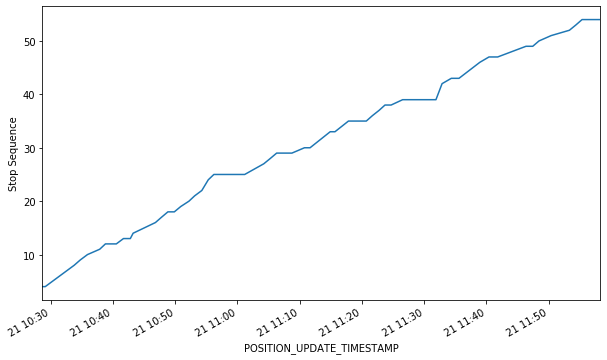

In [24]:
fig, (axis1) = plt.subplots(1,1,figsize=(10,6))
trip_on_field.plot("POSITION_UPDATE_TIMESTAMP","CURRENT_STOP_SEQUENCE",ax=axis1)
plt.legend().set_visible(False)
plt.ylabel("Stop Sequence")
plt

## Downloading larger datasets
Because of the large size of the data availabe, we have restricted PUDX "during" queries to only work when the time is less than one day. If data for a longer period is required, you will be needing the download API.
We will however need the resourceServerGroup id instead of the id for this. To find this, you can go to pudx.catalogue.iudx.org.in and search for ITMS with tags. Once the item is shown in the list view, you can click "details" and obtain the group id.
The resourceServerGroup id for itms is "urn:iudx-catalogue-pune:pudx-resource-server/pune-itms"

This will now give us a Google Drive link which we can use to download files based on weeks of the year. 

In [25]:
from pyIUDX.rs import rs

rs = rs.ResourceServer("https://pudx.resourceserver.iudx.org.in/resource-server/pscdcl/v1")

groupId = "urn:iudx-catalogue-pune:pudx-resource-server/pune-itms"

data = rs.downloadData(groupId)
data


{'download_URL': 'https://drive.google.com/open?id=1V9bp8D5M9nhqITjMvLo-1IoDltWsJlKs',
 'resourceServerGroup': 'urn:iudx-catalogue-pune:pudx-resource-server/pune-itms'}

On opening that download_URL, you will find different files corresponding to different weeks of the year for ITMS. You can then use python pyDrive module to download that file.

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from pydrive.files import GoogleDriveFile
from google.colab import auth
from oauth2client.client import GoogleCredentials

Authenticate with Google Drive. This will ask you to follow a link and allow access. You need to have a gmail account. Once you have accessed the link 

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
files = GoogleDriveFile(auth=gauth)

In [28]:

folder_id = data["download_URL"].split("=")[-1]
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()

for f in file_list:
  print(f["title"])

pune-itms-Week_39.json
pune-itms-Week_40.json
pune-itms-Week_41.json
pune-itms-Week_42.json
pune-itms-Week_43.json
pune-itms-Week_44.json
pune-itms-Week_45.json
pune-itms-Week_46.json
pune-itms-Week_48.json
pune-itms-Week_47.json


Currently only data for week 39 and 40 are made available. Let's download week 40's data.

In [0]:
fl = file_list[0]
fl.GetContentFile(fl["title"])


If we now see the directory, we will have the chosen file.json file, which we can read and proceed with our analysis as we had done before.

In [30]:
!ls

adc.json	    pune-itms-Week_39.json  sample_data
pune_ITMS_GTFS.zip  pune-itms-Week_40.json  targetdir


In [31]:
import json 

with open(fl["title"], "r") as f:
  df_json = json.load(f)
df_json[0:1]

[{'CURRENT_STATUS': 'IN_TRANSIT_TO',
  'CURRENT_STOP_SEQUENCE': 4.0,
  'LASTUPDATEDATETIME': '2019-09-29T18:30:10.000000+05:30',
  'LATITUDE_STR': 18.449968,
  'LONGITUDE_STR': 73.892,
  'NAME': '1140',
  'POSITION_UPDATE_TIMESTAMP': '2019-09-29T12:59:59Z',
  'ROUTE_ID': '187',
  'SCHEDULE_RELATIONSHIP': 'SCHEDULED',
  'STOP_ID': 152823.0,
  'StartTime_IST': 1569801610000,
  'TRIP_ID': 'NORMAL_187_Pune Station To Bhekrainagar_Down-0835_0',
  '__geoJsonLocation': {'coordinates': [73.892, 18.449968], 'type': 'Point'},
  '__resource-group': 'pune-itms',
  '__resource-id': 'pudx-resource-server/pune-itms/pune-itms-live'}]

In [32]:
""" Convert it to a dataframe and convert string values of fields to their proper types"""

df_field_data = pd.DataFrame(df_json)
df_field_data["POSITION_UPDATE_TIMESTAMP"] = pd.to_datetime(df_field_data["POSITION_UPDATE_TIMESTAMP"]).dt.tz_convert(pytz.timezone("Asia/Kolkata"))
df_field_data["LATITUDE_STR"] = pd.to_numeric(df_field_data["LATITUDE_STR"])
df_field_data["LONGITUDE_STR"] = pd.to_numeric(df_field_data["LONGITUDE_STR"])
""" Other fields which need to be converted """
df_field_data["STOP_ID"] = pd.to_numeric(df_field_data["STOP_ID"])
df_field_data["CURRENT_STOP_SEQUENCE"] = pd.to_numeric(df_field_data["CURRENT_STOP_SEQUENCE"])


df_field_data.head(3)

,__resource-group,POSITION_UPDATE_TIMESTAMP,LASTUPDATEDATETIME,LONGITUDE_STR,SCHEDULE_RELATIONSHIP,CURRENT_STOP_SEQUENCE,CURRENT_STATUS,ROUTE_ID,StartTime_IST,LATITUDE_STR,__geoJsonLocation,STOP_ID,TRIP_ID,__resource-id,NAME
0,pune-itms,2019-09-29 18:29:59+05:30,2019-09-29T18:30:10.000000+05:30,73.892000,SCHEDULED,4.0,IN_TRANSIT_TO,187,1569801610000,18.449968,"{'type': 'Point', 'coordinates': [73.892, 18.4...",152823.0,NORMAL_187_Pune Station To Bhekrainagar_Down-0...,pudx-resource-server/pune-itms/pune-itms-live,1140
1,pune-itms,2019-09-29 18:29:59+05:30,2019-09-29T18:30:11.000000+05:30,73.891396,SCHEDULED,37.0,IN_TRANSIT_TO,315,1569801611999,18.574280,"{'type': 'Point', 'coordinates': [73.891396, 1...",153401.0,NORMAL_315_Pune station To Bhosari via vishran...,pudx-resource-server/pune-itms/pune-itms-live,CNG446
2,pune-itms,2019-09-29 18:29:58+05:30,2019-09-29T18:30:10.000000+05:30,73.876630,SCHEDULED,7.0,IN_TRANSIT_TO,49,1569801610000,18.524202,"{'type': 'Point', 'coordinates': [73.87663, 18...",40552.0,NORMAL_49_Pune Station To Khanapur_Up-0715_0,pudx-resource-server/pune-itms/pune-itms-live,1685


Remember, this dataframe has data for multiple days of the week. If you were to plot the trips of this data, you will have overlaps corresponding to the same trip taken the next day. Let's do the same analysis as before and obtain trips with good data.

In [33]:
good_trips = df_field_data["TRIP_ID"].value_counts()[:50].index.tolist()
good_trips[:10]

['NORMAL_187_Pune Station To Bhekrainagar_Down-0835_0',
 'NORMAL_87_Susgaon Thaksen Nagar To Deccan Gymkhana_Down-0740_0',
 'NORMAL_158_Ma Na Pa To Lohgaon_Up-0700_0',
 'NORMAL_133_Ma Na Pa To Anand Park_Up-0940_0',
 'NORMAL_5_Pune Station To Swargate_Down-0625_0',
 'NORMAL_111_Bhekrainagar To Ma Na Pa_Up-0740_0',
 'NORMAL_174_Pune Station To NDA 10 No Gate Bus Stand_Up-1025_0',
 'NORMAL_169_Ma Na Pa To Keshavnagar (Vai Koregaon Park)_Up-0650_0',
 'NORMAL_87_Deccan Gymkhana To Sutarwadi Pashan (Vai Bhagvatinagar)_Up-0905_0',
 'NORMAL_197_Hadapsar Gadital To Kothrud Depot_Up-0735_0']

In [34]:
import numpy as np
from scipy.stats import entropy
from math import log, e

def column_entropy(column, base=None):
  vc = pd.Series(column).value_counts(normalize=True, sort=False)
  base = e if base is None else base
  return -(vc * np.log(vc)/np.log(base)).sum()
  
df_field_grouped = df_field_data.groupby(["TRIP_ID"])
score = []
""" Iterate through each trip """
for trip in good_trips:
  group = df_field_grouped.get_group(trip)
  entropy_pos = column_entropy(group["LONGITUDE_STR"])
  entropy_stop =  column_entropy(group["STOP_ID"])
  """ Compute score """
  score.append(entropy_pos * entropy_stop)

""" Get indexes of sorted scores """
good_trips_sorted_indexes = np.argsort(score)

""" The last one of the sorted indices is the one with the best score """
best_index = good_trips_sorted_indexes[-1]
good_trips_sorted_indexes

array([37, 35, 42, 25, 18,  8,  1, 13, 41, 15, 31, 14, 43, 29, 24, 38, 30,
        3, 16, 39,  2,  0, 22, 48, 45, 40, 46, 33, 26, 17, 47, 23,  5,  7,
        9, 34, 36, 20,  4, 27, 11, 10, 21, 32, 28, 19, 12, 44, 49,  6])

In [35]:
chosen_trip = good_trips[best_index]
trip_on_field = df_field_data.loc[df_field_data["TRIP_ID"] == chosen_trip]
trip_on_field.head(3)

,__resource-group,POSITION_UPDATE_TIMESTAMP,LASTUPDATEDATETIME,LONGITUDE_STR,SCHEDULE_RELATIONSHIP,CURRENT_STOP_SEQUENCE,CURRENT_STATUS,ROUTE_ID,StartTime_IST,LATITUDE_STR,__geoJsonLocation,STOP_ID,TRIP_ID,__resource-id,NAME
1635,pune-itms,2019-09-29 18:04:35+05:30,2019-09-29T18:36:11.000000+05:30,73.858116,SCHEDULED,3.0,STOPPED_AT,174,1569801971000,18.557260,"{'type': 'Point', 'coordinates': [73.858116, 1...",40109.0,NORMAL_174_Pune Station To NDA 10 No Gate Bus ...,pudx-resource-server/pune-itms/pune-itms-live,1566
1651,pune-itms,2019-09-29 18:04:23+05:30,2019-09-29T18:04:46.000000+05:30,73.861570,SCHEDULED,3.0,STOPPED_AT,174,1569800086999,18.555582,"{'type': 'Point', 'coordinates': [73.86157, 18...",40109.0,NORMAL_174_Pune Station To NDA 10 No Gate Bus ...,pudx-resource-server/pune-itms/pune-itms-live,1566
1783,pune-itms,2019-09-29 18:01:50+05:30,2019-09-29T18:04:16.000000+05:30,73.867350,SCHEDULED,3.0,STOPPED_AT,174,1569800056000,18.551275,"{'type': 'Point', 'coordinates': [73.86735, 18...",40109.0,NORMAL_174_Pune Station To NDA 10 No Gate Bus ...,pudx-resource-server/pune-itms/pune-itms-live,1566


Now let's see the time evolution of stops.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

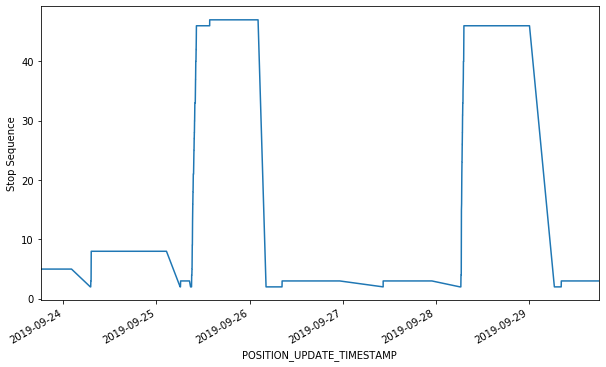

In [36]:
fig, (axis1) = plt.subplots(1,1,figsize=(10,6))
trip_on_field.plot("POSITION_UPDATE_TIMESTAMP","CURRENT_STOP_SEQUENCE",ax=axis1)
plt.legend().set_visible(False)
plt.ylabel("Stop Sequence")
plt

You can now compare the time of arrival to a particular stop using this.

## Getting real time data

For datasets like ITMS, getting real time data is a little tricky. 
We will need to perform a **during** query with the time interval being between now and n-minutes ago.

In [0]:
from pyIUDX.rs import rs
from datetime import datetime, timedelta
import pytz
import time
from IPython.display import display


ist = pytz.timezone('Asia/Kolkata')

rs = rs.ResourceServer("https://pudx.resourceserver.iudx.org.in/resource-server/pscdcl/v1")

id = "rbccps.org/aa9d66a000d94a78895de8d4c0b3a67f3450e531/pudx-resource-server/pune-itms/pune-itms-live"
m = folium.Map(location=[18.5204,73.8567],zoom_start=13)
time_delta = 1

Let's plot it live. Use the stop execution button on the left side of the cell to stop plotting live

In [38]:
while(True):
  try:
    time.sleep(10)
    endTime = datetime.strftime(datetime.now(ist), "%Y-%m-%dT%H:%M:%S.%f")[:-3] + "+05:30"
    startTime = datetime.strftime(datetime.now(ist) - timedelta(minutes=time_delta), "%Y-%m-%dT%H:%M:%S.%f")[:-3] + "+05:30"

    """ Now perform a during query with these timestamps """
    field_data = rs.getDataDuring(id, startTime, endTime)
    df_live = pd.DataFrame(field_data)
    
    df_live["POSITION_UPDATE_TIMESTAMP"] = pd.to_datetime(df_live["POSITION_UPDATE_TIMESTAMP"]).dt.tz_localize("UTC").dt.tz_convert(pytz.timezone("Asia/Kolkata"))
    df_live["LATITUDE_STR"] = pd.to_numeric(df_live["LATITUDE_STR"])
    df_live["LONGITUDE_STR"] = pd.to_numeric(df_live["LONGITUDE_STR"])
    """ Other fields which need to be converted """
    df_live["STOP_ID"] = pd.to_numeric(df_live["STOP_ID"])
    df_live["CURRENT_STOP_SEQUENCE"] = pd.to_numeric(df_live["CURRENT_STOP_SEQUENCE"])

    df_live.head(2)
    for index, row in df_live.iterrows():
      ll = [row["LATITUDE_STR"], row["LONGITUDE_STR"]]
      folium.Marker(ll, popup=str(row["TRIP_ID"]), icon=folium.Icon(color='green')).add_to(m)
    display(m)
  except Exception as e:
    pass

KeyboardInterrupt: ignored

You can keep refreshing the above to notice the busses moving.